In [17]:
import numpy as np
import pandas as pd

In [18]:
df = pd.read_csv("powerconsumption.csv")

df = df[['Datetime', 'Temperature', 'Humidity', 'PowerConsumption_Zone1']]

df

,Datetime,Temperature,Humidity,PowerConsumption_Zone1
0,2017-01-01 00:00:00,6.559,73.8,34055.69620
1,2017-01-01 00:10:00,6.414,74.5,29814.68354
2,2017-01-01 00:20:00,6.313,74.5,29128.10127
3,2017-01-01 00:30:00,6.121,75.0,28228.86076
4,2017-01-01 00:40:00,5.921,75.7,27335.69620
...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,31160.45627
52412,2017-12-30 23:20:00,6.947,72.6,30430.41825
52413,2017-12-30 23:30:00,6.900,72.8,29590.87452
52414,2017-12-30 23:40:00,6.758,73.0,28958.17490


Для покращення видимості аномальних точок на графіку, зменшимо розмір таблиці, обчисливши середнє значення даних (52416 рядків ділиться на 6)

In [19]:
df['group'] = np.arange(len(df)) // 6

mean_vals = df.groupby('group').mean(numeric_only=True)
timestamps = df.groupby('group')['Datetime'].last()

df_reduced = mean_vals.join(timestamps).reset_index(drop=True)

df_reduced

,Temperature,Humidity,PowerConsumption_Zone1,Datetime
0,6.196833,75.066667,29197.974683,2017-01-01 00:50:00
1,5.548833,77.583333,24657.215190,2017-01-01 01:50:00
2,5.054333,78.933333,22083.037973,2017-01-01 02:50:00
3,5.004333,77.083333,20811.139240,2017-01-01 03:50:00
4,5.097667,74.050000,20475.949367,2017-01-01 04:50:00
...,...,...,...,...
8731,9.453333,62.406667,37513.814957,2017-12-30 19:50:00
8732,9.041667,63.990000,37008.871988,2017-12-30 20:50:00
8733,8.011667,69.675000,35358.174905,2017-12-30 21:50:00
8734,7.598333,70.315000,33993.409380,2017-12-30 22:50:00


In [20]:
from matplotlib import pyplot as plt


def plot_anomalies(dataframe, method, column, colors):
    anomalies = dataframe[dataframe[method] == -1] if method != 'Z_Score' else dataframe[dataframe[method] == 1]

    plt.figure(figsize=(15, 6))
    plt.plot(dataframe['Datetime'], dataframe[column], label=column, color=colors[column])
    plt.scatter(anomalies['Datetime'], anomalies[column], label=f'{column} Anomalies', color='k')

    plt.title(f'{column} - Method: ({method})')
    plt.xlabel('Datetime')
    plt.ylabel('Values')
    plt.xticks([])
    plt.legend()
    plt.show()

clrs = {'Temperature': 'm', 'Humidity': 'y', 'PowerConsumption_Zone1': 'c'}

Isolation Forest

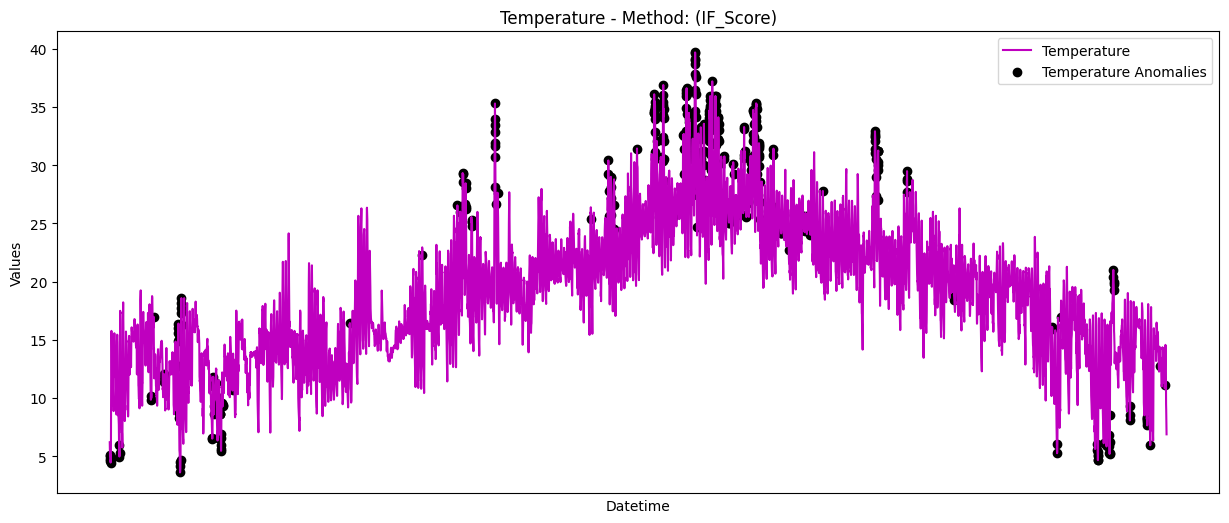

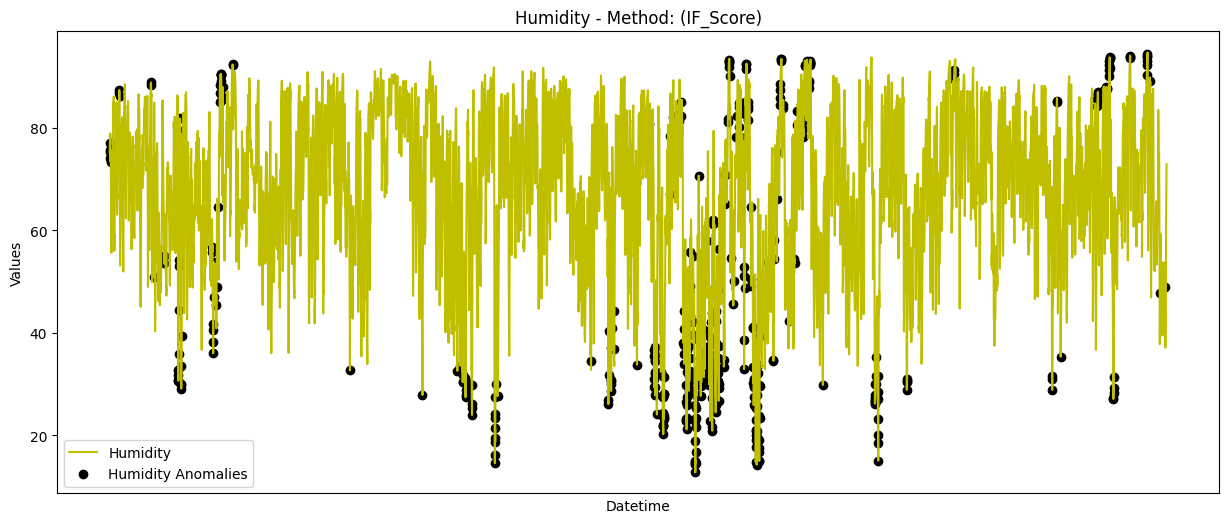

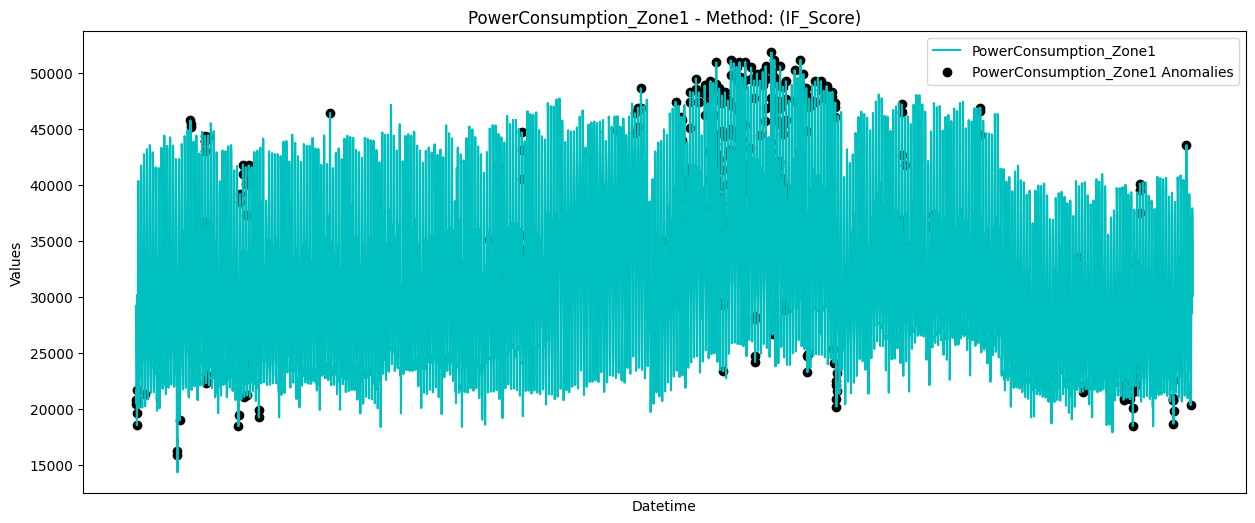

In [21]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.05)
df_reduced['IF_Score'] = isolation_forest.fit_predict(df_reduced[['Temperature', 'Humidity', 'PowerConsumption_Zone1']])
plot_anomalies(df_reduced, 'IF_Score', 'Temperature', clrs)
plot_anomalies(df_reduced, 'IF_Score', 'Humidity', clrs)
plot_anomalies(df_reduced, 'IF_Score', 'PowerConsumption_Zone1', clrs)

Local Outlier Factor

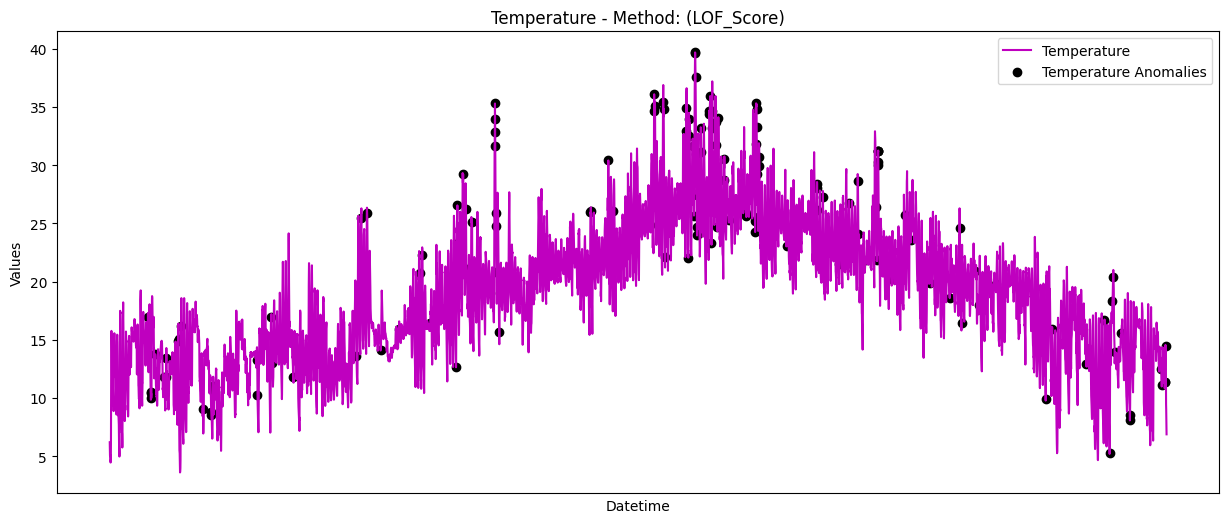

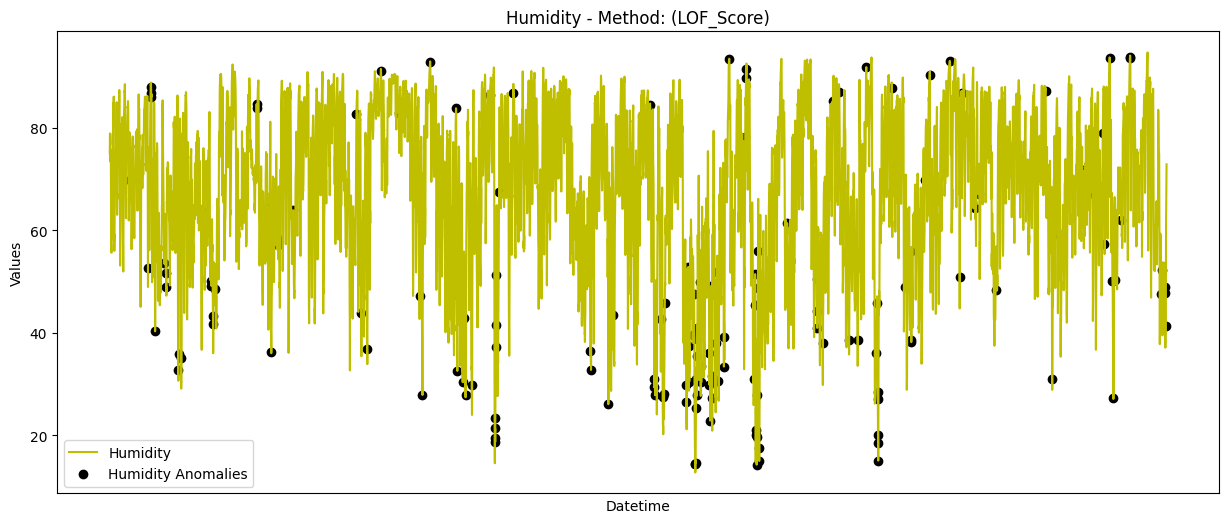

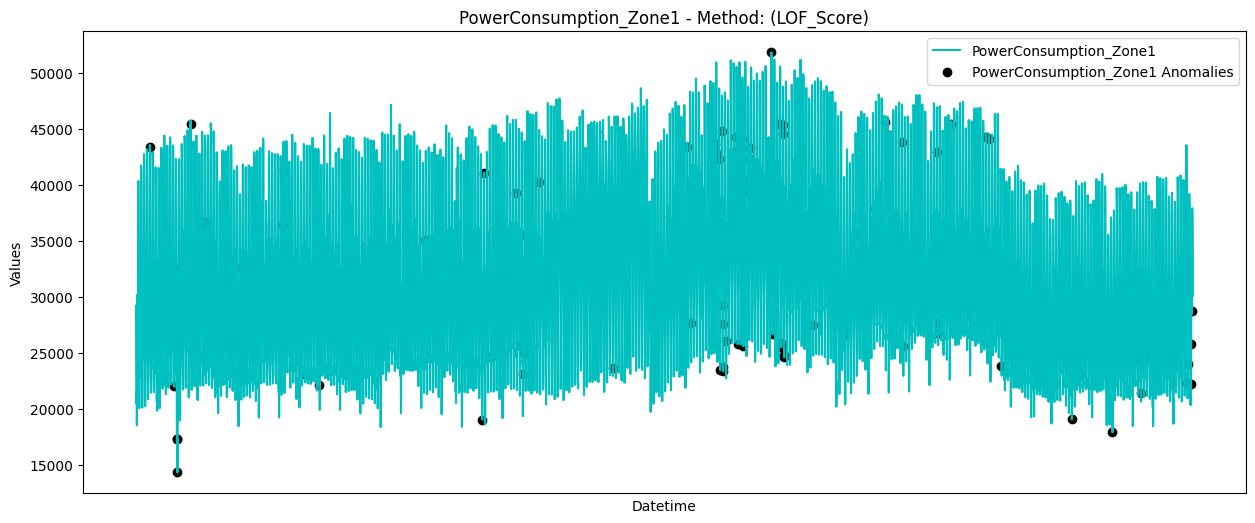

In [22]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=5)
df_reduced['LOF_Score'] = lof.fit_predict(df_reduced[['Temperature', 'Humidity','PowerConsumption_Zone1']])
plot_anomalies(df_reduced, 'LOF_Score', 'Temperature', clrs)
plot_anomalies(df_reduced, 'LOF_Score', 'Humidity', clrs)
plot_anomalies(df_reduced, 'LOF_Score', 'PowerConsumption_Zone1', clrs)

Z-score

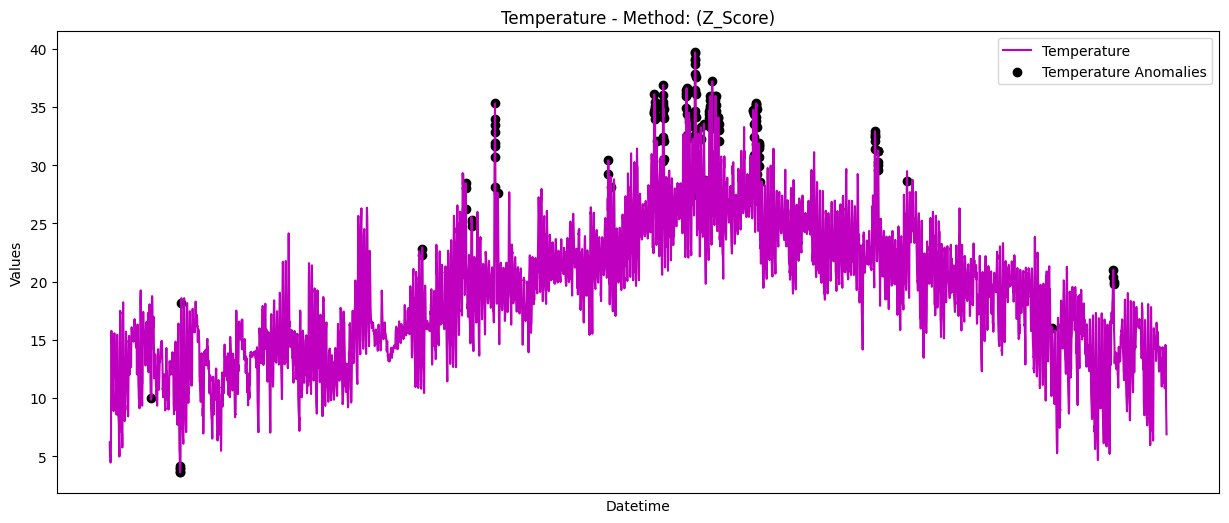

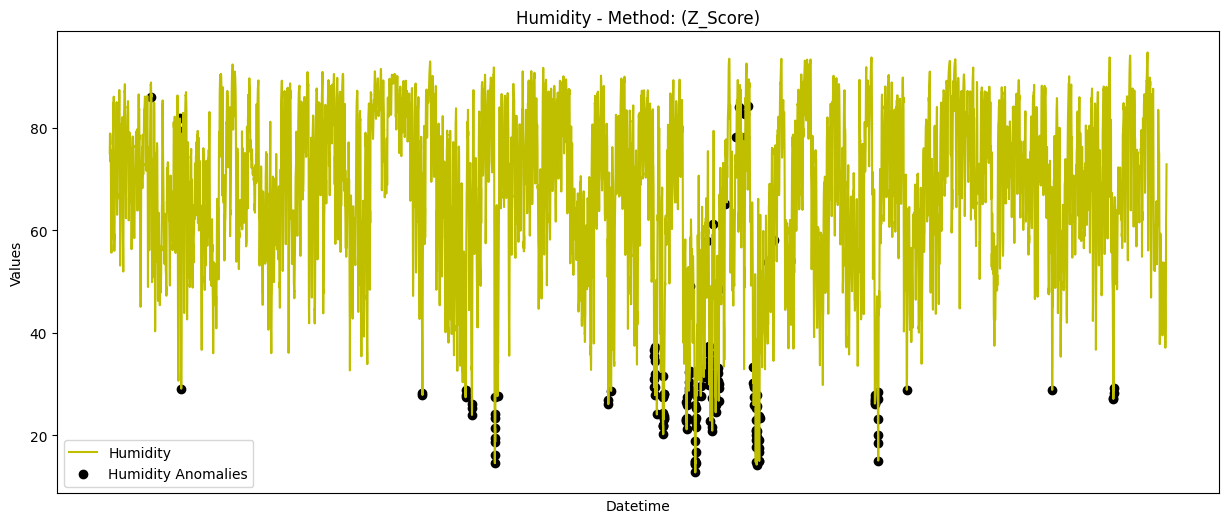

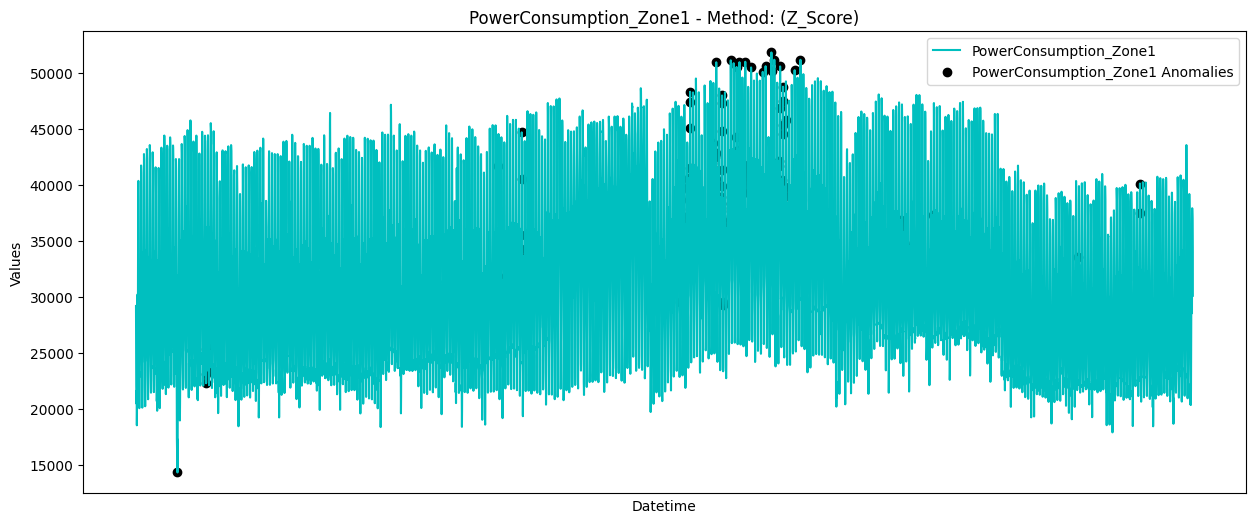

In [23]:
from scipy import stats

z_scores = np.abs(stats.zscore(df_reduced[['Temperature', 'Humidity','PowerConsumption_Zone1']]))
df_reduced['Z_Score'] = (z_scores > 2.5).any(axis=1).astype(int)
plot_anomalies(df_reduced, 'Z_Score', 'Temperature', clrs)
plot_anomalies(df_reduced, 'Z_Score', 'Humidity', clrs)
plot_anomalies(df_reduced, 'Z_Score', 'PowerConsumption_Zone1', clrs)

В цілому, часовий ряд "Power Consumption" має більш-менш однорідні дані, тому всі алгоритми показали багато хибних аномальних точок, в той час, як всі інші ряди були легшими у визначенні аномалій